
                                     Matthew Inglis-Whalen (GoalZone Data Science Team Member)
                                                                                   August 2023

Many of our members make bookings for our fitness classes but then don't show up for their booked class. Since many of our classes are fully booked, this prevents other paying members from attending the class. We would like to be able to predict when a booking will be a no-show with high confidence -- when such a booking is identified, we could add another spot to the class, allowing our fully booked classes to have a full attendance on the day.

From the data I have been provided, here is a quick summary of the analysis. The data was a little messy, with some missing values, so I needed to perform some cleanup and imputation. Exploring the data showed that only 30% of bookings actually showed up for the class, giving a fairly imbalanced dataset across the two attended/not-attended classifications. Across the dataset, more bookings are performed by people that have only been a member for a shorter period of time: a median membership period of 12 months is observed, compared to a mean membership duration of 15.6 months, implying that there are quite a lot more new members making bookings than older members. Interestingly, despite being less prevalent in the dataset, we also see that bookings from people that have been a member for a longer period of time are more likely to attend the booked class. 

In order to predict whether a member will actually attend their booked class, I've looked at two models: a simple Logistic Regression Classifier and a Support Vector Machine Classifeir (SVM). Based on balanced accuracy I've decided that the **Logistic Regression** model worked the best for predicting attendance. This model has achieved a 75% balanced accuracy across both the training and test sets, and therefore should be sufficient for deciding when to add additional slots for our classes.

In [1]:
# base packages
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('darkgrid')
sns.set_palette('colorblind')

# data validation 
import missingno as miss

# exploration
from sklearn.decomposition import PCA

# train/test systems
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

# timing
from time import perf_counter

# machine learning classifier models to try
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# learning more about the fit models
from sklearn.inspection import permutation_importance

In [2]:
# for analyzing categorical variables after the model has been fit
def unget_dummies(df, prefix_sep="-"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

# Data Validation

- Import data
- Check missingness
- Impute missing values
- Clean outstanding issues

Here's the dataset:

In [3]:
# load and inspect the data
fitness_raw = pd.read_csv('fitness_class_2212.csv')
fitness_raw

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.51,10,Fri,AM,HIIT,0
1496,1497,29,89.55,2,Mon,AM,Strength,0
1497,1498,9,87.38,4,Tue,AM,HIIT,0
1498,1499,34,68.64,14,Sun,AM,Aqua,0


I'll go through the dataset column by column, checking that the data agrees with the provided description, and fixing any descrepancies.

First is the `booking_id` column, which acts as a unique identifier for each entry. There were no missing values and no duplicates, as claimed by the description.

In [4]:
# check for duplicated ids
print(f"Num missing: {fitness_raw['booking_id'].isna().sum()}")
print(f"Num duplicated: {fitness_raw['booking_id'].duplicated().sum()}")
print(f"Num unique: {fitness_raw['booking_id'].nunique()} vs total number of rows {len(fitness_raw['booking_id'])}")

Num missing: 0
Num duplicated: 0
Num unique: 1500 vs total number of rows 1500


Next is the `months_as_a_member` column. There were no missing values, and all values lie in an acceptable range (1 month to 148 months of membership) with dtype int

In [5]:
print(f"Num missing: {fitness_raw['months_as_member'].isna().sum()}")
print(f"months_as_member dtype: {fitness_raw['months_as_member'].dtypes}")
fitness_raw['months_as_member'].describe()

Num missing: 0
months_as_member dtype: int64


count    1500.000000
mean       15.628667
std        12.926543
min         1.000000
25%         8.000000
50%        12.000000
75%        19.000000
max       148.000000
Name: months_as_member, dtype: float64

In [6]:
fitness_raw['months_as_member'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  47,  48,  50,  51,  52,  53,  54,
        55,  57,  58,  59,  60,  61,  62,  65,  66,  69,  73,  76,  89,
        90,  93,  97, 105, 107, 111, 148])

The `weight` column is next. We see 20 missing values, with minimum 55.41 kg and maximum 170.52 kg. I'll impute the missing values with the average weight (82.61)

In [7]:
print(f"Num missing: {fitness_raw['weight'].isna().sum()}")
print(f"weight dtype: {fitness_raw['weight'].dtypes}")
fitness_raw['weight'].describe()

Num missing: 20
weight dtype: float64


count    1480.000000
mean       82.610378
std        12.765859
min        55.410000
25%        73.490000
50%        80.760000
75%        89.520000
max       170.520000
Name: weight, dtype: float64

In [8]:
fitness_raw['weight'].fillna(value=fitness_raw['weight'].mean(),inplace=True)

# Check the fillna did what I expected
print(f"Num missing now: {fitness_raw['weight'].isna().sum()}\nMode={fitness_raw['weight'].mode().values[0]:.2f} equal to the mean {fitness_raw['weight'].mean():.2f} due to the mean-fill.")

Num missing now: 0
Mode=82.61 equal to the mean 82.61 due to the mean-fill.


Now looking at the `days_before` columns, there are no missing values, but it has the wrong dtype. This column should be an integer, but it has been read by pandas as a string object. Looking at the unique values, this is because some of the rows contain " days" appended to the actual number. I've stripped off these unnecessary string fragments and ensured the column is of an integer data type.

In [9]:
print(f"Num missing: {fitness_raw['days_before'].isna().sum()}")
print(f"days_before dtype: {fitness_raw['days_before'].dtypes}")
fitness_raw['days_before'].unique()

Num missing: 0
days_before dtype: object


array(['8', '2', '14', '10', '6', '4', '9', '12', '5', '3', '7', '13',
       '12 days', '20', '1', '15', '6 days', '11', '13 days', '3 days',
       '16', '1 days', '7 days', '8 days', '10 days', '14 days', '17',
       '5 days', '2 days', '4 days', '29'], dtype=object)

Now we can see that the range of `days_before` is appropriate, lying anywhere from 1 day to 29 days before the class.

In [10]:
fitness_raw['days_before'] = fitness_raw['days_before'].str.replace(' days','').astype(int)
print(f"days_before dtype now: {fitness_raw['days_before'].dtypes}")
fitness_raw['days_before'].describe()

days_before dtype now: int64


count    1500.000000
mean        8.346667
std         4.077938
min         1.000000
25%         4.000000
50%         9.000000
75%        12.000000
max        29.000000
Name: days_before, dtype: float64

Next is the `day_of_week` column. There are no missing values, but some of the entries are not standardized. For example, both 'Mon' and 'Monday' appear in the list of values. I'll standardize these strings by taking only the first 3 characters of each string.

In [11]:
print(f"Num missing: {fitness_raw['day_of_week'].isna().sum()}")
print(f"days_before dtype: {fitness_raw['day_of_week'].dtypes}")
fitness_raw['day_of_week'].unique()

Num missing: 0
days_before dtype: object


array(['Wed', 'Mon', 'Sun', 'Fri', 'Thu', 'Wednesday', 'Fri.', 'Tue',
       'Sat', 'Monday'], dtype=object)

In [12]:
fitness_raw['day_of_week'] = fitness_raw['day_of_week'].str[:3]
fitness_raw['day_of_week'].unique()

array(['Wed', 'Mon', 'Sun', 'Fri', 'Thu', 'Tue', 'Sat'], dtype=object)

Now looking at the `time` column, there are no missing values and all values are either 'AM' or 'PM', as expected.

In [13]:
print(f"Num missing: {fitness_raw['time'].isna().sum()}")
print(f"days_before dtype: {fitness_raw['time'].dtypes}")
fitness_raw['time'].unique()

Num missing: 0
days_before dtype: object


array(['PM', 'AM'], dtype=object)

Next is the `category` column. There are no _missing_ values, but that's because the missing values have been coded as '-'. I'll replace these missing values with 'unknown'.


In [14]:
print(f"Num missing: {fitness_raw['category'].isna().sum()}")
print(f"days_before dtype: {fitness_raw['category'].dtypes}")
fitness_raw['category'].unique()

Num missing: 0
days_before dtype: object


array(['Strength', 'HIIT', 'Cycling', 'Yoga', '-', 'Aqua'], dtype=object)

In [15]:
fitness_raw['category'] = fitness_raw['category'].str.replace('-','unknown')
print(fitness_raw['category'].value_counts())
fitness_raw['category'].unique()

HIIT        667
Cycling     376
Strength    233
Yoga        135
Aqua         76
unknown      13
Name: category, dtype: int64


array(['Strength', 'HIIT', 'Cycling', 'Yoga', 'unknown', 'Aqua'],
      dtype=object)

Finally, the `attended` column. There are no missing values, and the values are either 0 or 1, as expected


In [16]:
print(f"Num missing: {fitness_raw['attended'].isna().sum()}")
print(f"days_before dtype: {fitness_raw['attended'].dtypes}")
fitness_raw['attended'].unique()

Num missing: 0
days_before dtype: int64


array([0, 1])

### Summary of columns

There were 1500 rows and 8 columns. 
Description of the columns:

- 1 ≤ booking_id ≤ 1500 -- id of the booking, no missing values, same as description in the instructions. No cleaning needed. 
- 1 ≤ months_as_member ≤ 148 -- integer, as described, no missing values.
- 55.41 ≤ weight ≤ 170.52 -- float, as described, but with 20 missing values. Null values filled with mean value of 82.61
- 1 ≤ days_before ≤ 29 -- integer, no missing values. Not as described, since it required " days" string to be stripped off to ensure int data type.
- day_of_week ∈ \['Sun','Mon','Tue','Wed','Thu','Fri','Sat'\] -- string, no missing values. Not as described, since it required standardization of day coding to conform to provided description of 3-letter codings.
- time ∈ \['AM','PM'\] -- string, as described, no missing values
- category ∈ \['Strength','HIIT','Cycling','Yoga,'Aqua','unknown'\] -- string. Not as described, since 13 'missing' values were coded as '-', which were converted to the string 'unknown'. 
- attended ∈ \[0,1\] -- integer, as described, no missing values

# Exploratory Analysis

Let's examine how many people actually showed up to their booked class. The bar chart below shows that of the 1500 bookings, only 454 (30.3%) showed up to their class, while in contrast 1046 (69.7%) did *not* show up for their booking.

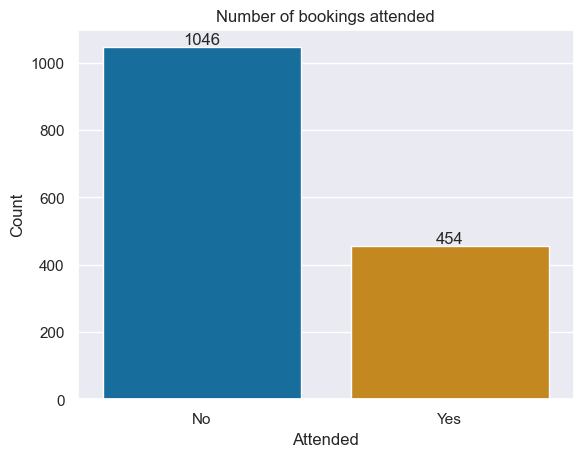

In [17]:
fig, ax = plt.subplots()
g = sns.countplot(data=fitness_raw,x='attended',ax=ax)
g.bar_label(g.containers[0])
ax.set_xlabel('Attended')
ax.set_ylabel('Count')
g.set(xticklabels=["No","Yes"])
ax.set_title('Number of bookings attended')
plt.show()

Therefore, the observations in our dataset are not balanced across the label column `attended`, since there is more -- roughly 2.3x as many -- 'not attended' entries as 'attended' entries

Let's now look at how long each booking has been a member. We can see a unimodel distribution that resembles a normal distribution in log-x space, i.e P(x) ~ Aexp(-Blog^2(x)). The most frequent value for `months_as_member` is 8, with a median of 12 and a mean of about 15.6. Transforming this column using a logarithm should help a model distinguish between low and very-low values.

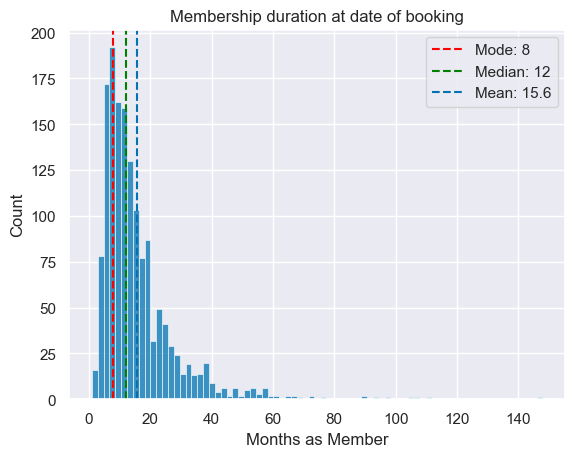

In [18]:
fig, ax = plt.subplots()
g = sns.histplot(data=fitness_raw,x='months_as_member',ax=ax)
ax.set_xlabel('Months as Member')
ax.set_ylabel('Count')
ax.set_title('Membership duration at date of booking')
mode = fitness_raw['months_as_member'].mode().values[0]
mean = fitness_raw['months_as_member'].mean()
median = fitness_raw['months_as_member'].median()
plt.axvline(x=mode, label=f"Mode: {mode}", linestyle='--',color='red')
plt.axvline(x=median, label=f"Median: {median:.0f}", linestyle='--',color='green')
plt.axvline(x=mean, label=f"Mean: {mean:.1f}", linestyle='--')
plt.legend()
plt.show()

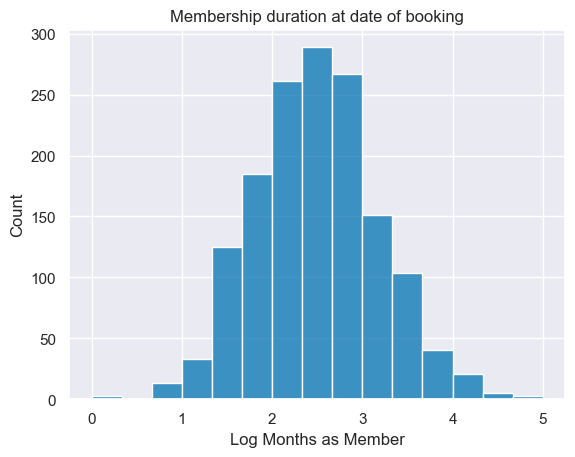

In [19]:
fitness_raw['Lmonths'] = np.log(fitness_raw['months_as_member'])
fig, ax = plt.subplots()
g = sns.histplot(data=fitness_raw,x='Lmonths',ax=ax,bins=15)
ax.set_xlabel('Log Months as Member')
ax.set_ylabel('Count')
ax.set_title('Membership duration at date of booking')
plt.show()

Now I'll investigate whether the number of months of membership affects the attendance rate. New members are very likely to skip their booked class, with the probability of attendance increasing roughly logistically with membership duration. According to a logistic (sigmoidal) fit to the data on the left, after 75 months of membership attendance is practically guaranteed. The plot on the right suggests that `logged months` is a better variable for a logistic fit, as used in logistic regression classifiers.

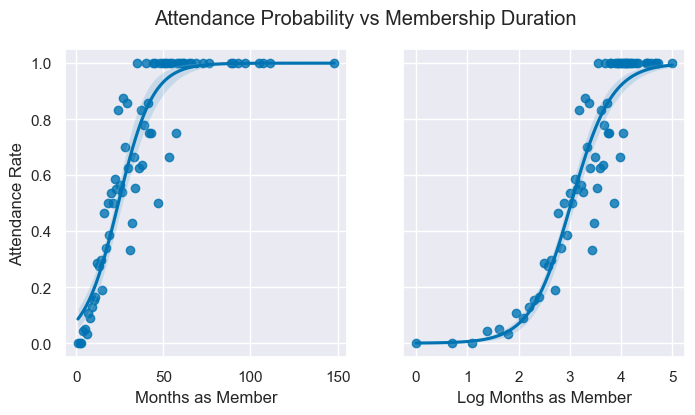

In [20]:
fig_month_data, axs = plt.subplots(1,2,figsize=(8,4), sharey=True)

attendance_proportion_months = fitness_raw.groupby('months_as_member',as_index=False)['attended'].mean()
g1 = sns.regplot(data=attendance_proportion_months,x='months_as_member',y='attended', logistic=True, ax=axs[0])
g1.set(xlabel='Months as Member')
g1.set(ylabel='Attendance Rate')

attendance_proportion_Lmonths = fitness_raw.groupby('Lmonths',as_index=False)['attended'].mean()
g_lmonth_data = sns.regplot(data=attendance_proportion_Lmonths,x='Lmonths',y='attended', logistic=True, ax=axs[1])
g_lmonth_data.set(xlabel='Log Months as Member')
g_lmonth_data.set(ylabel='')

plt.suptitle('Attendance Probability vs Membership Duration')
plt.show()

There are a few other variables we can examine for attendance trends. We can see that most classes have similar attendance records except for those classes with an unknown type, which have worse attendance records.

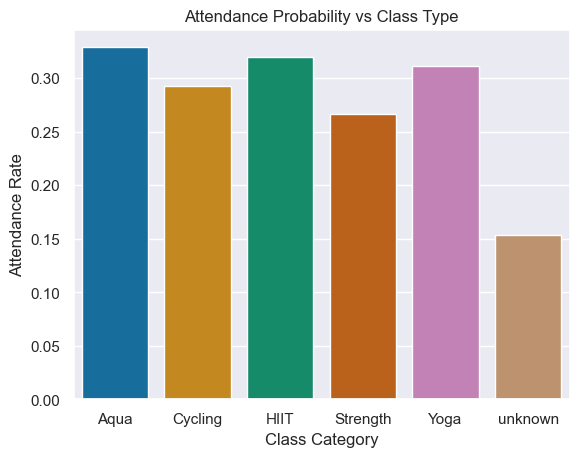

In [21]:
attendance_proportion_category = fitness_raw.groupby('category',as_index=False)['attended'].mean()
fig, ax = plt.subplots()
sns.barplot(data=attendance_proportion_category,x='category',y='attended', ax=ax)
ax.set_xlabel('Class Category')
ax.set_ylabel('Attendance Rate')
ax.set_title('Attendance Probability vs Class Type')
plt.show()

We can also see that most days have similar attendance records, except for Wednesday afternoon, which has an attendance rate of ~16%.

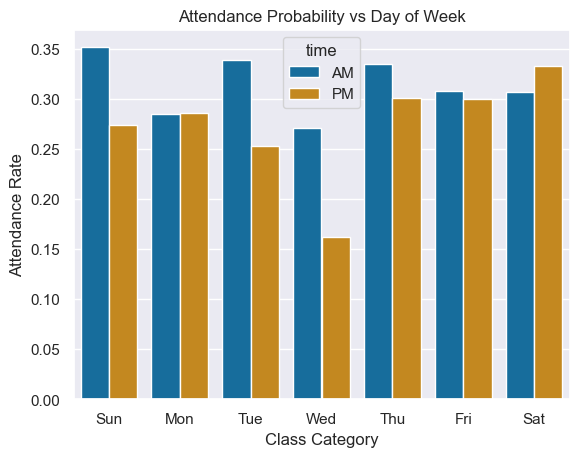

In [22]:
attendance_proportion_category = fitness_raw.groupby(['day_of_week','time'],as_index=False)['attended'].mean()
fig_daytime_data, ax = plt.subplots()
sns.barplot(data=attendance_proportion_category,x='day_of_week',y='attended', hue='time',ax=ax, order=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
ax.set_xlabel('Class Category')
ax.set_ylabel('Attendance Rate')
ax.set_title('Attendance Probability vs Day of Week')
plt.show()

It also appears that there is no significant correlation between attendance rate and how long before the class the booking was made.

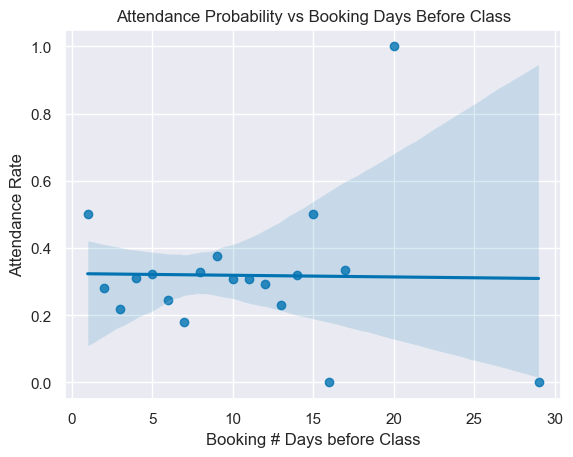

In [23]:
attendance_proportion_before = fitness_raw.groupby('days_before',as_index=False)['attended'].mean()
fig, ax = plt.subplots()
sns.regplot(data=attendance_proportion_before,x='days_before',y='attended', ax=ax)
ax.set_xlabel('Booking # Days before Class')
ax.set_ylabel('Attendance Rate')
ax.set_title('Attendance Probability vs Booking Days Before Class')
plt.show()

In [24]:
def get_binxs_props_sigmas(df, col_name, label_col='attended') :
    """ Get bin position, the proportion of attendance in that bin, and the associated standard error"""
    bins = np.linspace(np.min(df[col_name]),np.max(df[col_name])+1e-5,8,endpoint=True)
    bin_mids = []
    props = []
    errs = []

    for bin_low, bin_high in zip(bins[:-1],bins[1:]) :
        
        mask = (bin_low <= df[col_name]) & (df[col_name] < bin_high)
        tmp_prop = df[mask][label_col].mean()  # the proportions
        tmp_count = len(df[mask])               # count all in the bin. For error bars

        bin_mids.append( (bin_low+bin_high)/2 )
        props.append(tmp_prop)
        
        # print(bin_low, bin_high, tmp_prop,tmp_count)
        
        # from usual binomial variance V_count = np(1-p), sigma_count = sqrt(np(1-p)) so sigma prop = sqrt(p(1-p)/n)
        errs.append( (np.sqrt(tmp_prop*(1-tmp_prop)/(tmp_count-1) ) if tmp_count>1 else 0.5 if tmp_prop > 0.5 else 0,
                      np.sqrt(tmp_prop*(1-tmp_prop)/(tmp_count-1) ) if tmp_count>1 else 0.5 if tmp_prop < 0.5 else 0) ) 
                      # also correct for fact you can't estimate variance from a single data point
            
    for idx, prop in enumerate(props) :
        if np.isnan(prop):
            props[idx] = np.nanmean(props)
        
    return bin_mids, props, np.transpose(errs)

By binning the weights of the members, we can also see that the bookings involving a heavier member are less likely to be attended, while the lighter members are more likely to attend their booking.

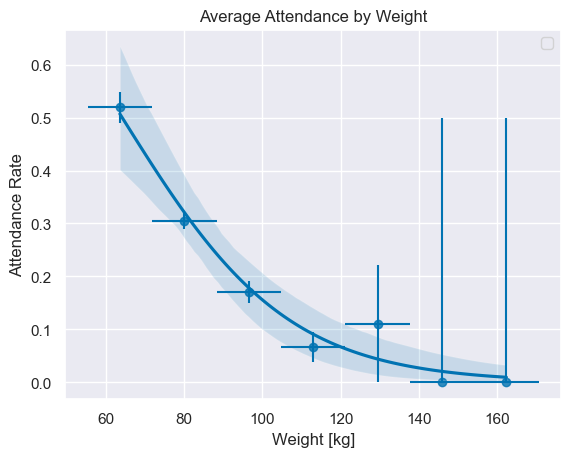

In [25]:
bins_weight, props_weight, errs_weight  = get_binxs_props_sigmas(fitness_raw,'weight')
corr_coef_weight = np.corrcoef(bins_weight, props_weight)[0,1]
fig_weight_data, ax = plt.subplots()
g = sns.regplot(x=bins_weight,y=props_weight, ax=ax, logistic=True)
ax.errorbar(x=bins_weight, y=props_weight, yerr=errs_weight, xerr=(bins_weight[1]-bins_weight[0])/2, ecolor=sns.color_palette()[0],ls='None' )
g.set(xlabel="Weight [kg]")
g.set(ylabel="Attendance Rate")
g.set(title="Average Attendance by Weight")
ax.legend()
plt.show()

If I examine the scatterplot (below) of membership duration vs weight, with coloring applied for whether the booking was attended or not, it can be seen that there exists a negative correlation between weight and membership duration. It is perhaps more interesting to observe, however, that the members which attend their class are clustered in a region of low-weight and high membership duration. Perhaps then a clustering model (e.g. KNN or SVM) could help turn this observation into a predictive model.

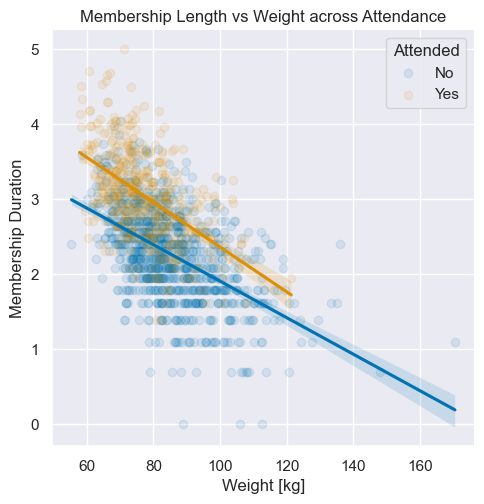

In [26]:
g = sns.lmplot(data=fitness_raw, x='weight',y='Lmonths', hue='attended', legend_out=False, scatter_kws={'alpha':0.1})
g.set(xlabel='Weight [kg]')
g.set(ylabel='Membership Duration')
g.set(title='Membership Length vs Weight across Attendance')
g._legend.set_title('Attended')
for t, l in zip(g._legend.texts, ['No','Yes']):
    t.set_text(l)
    
fig_lengthweight_data = g.figure
plt.show()

# Modeling

Before jumping into model genesis and fitting, let's first select our features and labels, turn our categorical features into one-hot encoded columns, and split into a train/test set. Then after standard scaling the numerical features, the training set looks like

In [27]:
X = fitness_raw[['Lmonths','weight','days_before','day_of_week','time','category']]
y = fitness_raw['attended']

X_onehot = pd.get_dummies(X,prefix_sep='-')

# make sure we haven't leaked labels
print("This should contain no label information: ", X_onehot.columns)

X_train, X_test, y_train, y_test = train_test_split(X_onehot,y,test_size=0.2,stratify=y, random_state=2023)

# these will be useful for interpreting what the models have learned
all_train = X_train.copy()
all_train['months_as_member'] = np.exp(all_train['Lmonths'])
all_train['attended'] = y_train.copy()

This should contain no label information:  Index(['Lmonths', 'weight', 'days_before', 'day_of_week-Fri',
       'day_of_week-Mon', 'day_of_week-Sat', 'day_of_week-Sun',
       'day_of_week-Thu', 'day_of_week-Tue', 'day_of_week-Wed', 'time-AM',
       'time-PM', 'category-Aqua', 'category-Cycling', 'category-HIIT',
       'category-Strength', 'category-Yoga', 'category-unknown'],
      dtype='object')


In [28]:
# Now we standard scale the numerical columns, so they have similar standard deviations to the categorical feature ont-hot encodings

numerical_list = ['Lmonths','weight','days_before']
# numerical_list = ['months_as_member','weight','days_before']

for X_set in [X_train, X_test] :

    for feature in numerical_list :
        mu, sigma = X_set[feature].mean(), X_set[feature].std()
        X_set[feature] = (X_set[feature]-mu)/sigma
        
# make sure the columns are scaled properly
print(X_train[numerical_list].describe())
print(X_test[numerical_list].describe())

            Lmonths        weight   days_before
count  1.200000e+03  1.200000e+03  1.200000e+03
mean   1.598721e-16  6.624331e-16  2.324067e-16
std    1.000000e+00  1.000000e+00  1.000000e+00
min   -3.619617e+00 -2.155105e+00 -1.857727e+00
25%   -6.094221e-01 -7.029293e-01 -8.631819e-01
50%   -2.247161e-02 -1.543472e-01  3.799989e-01
75%    6.427464e-01  5.347807e-01  8.772712e-01
max    3.614337e+00  6.921041e+00  5.104086e+00
            Lmonths        weight   days_before
count  3.000000e+02  3.000000e+02  3.000000e+02
mean  -2.190840e-16 -9.118632e-16 -2.960595e-17
std    1.000000e+00  1.000000e+00  1.000000e+00
min   -2.597818e+00 -1.889142e+00 -1.605304e+00
25%   -6.217936e-01 -7.230070e-01 -9.019091e-01
50%   -4.384361e-02 -5.101012e-02  3.595131e-02
75%    6.111738e-01  4.930155e-01  9.738117e-01
max    3.127135e+00  3.329876e+00  2.849532e+00


In [29]:
X_train.describe()

,Lmonths,weight,days_before,day_of_week-Fri,day_of_week-Mon,day_of_week-Sat,day_of_week-Sun,day_of_week-Thu,day_of_week-Tue,day_of_week-Wed,time-AM,time-PM,category-Aqua,category-Cycling,category-HIIT,category-Strength,category-Yoga,category-unknown
count,1.200000e+03,1.200000e+03,1.200000e+03,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,1.598721e-16,6.624331e-16,2.324067e-16,0.212500,0.140833,0.135833,0.144167,0.161667,0.125000,0.080000,0.763333,0.236667,0.051667,0.258333,0.435000,0.154167,0.092500,0.008333
std,1.000000e+00,1.000000e+00,1.000000e+00,0.409247,0.347995,0.342754,0.351405,0.368298,0.330857,0.271406,0.425213,0.425213,0.221445,0.437901,0.495964,0.361259,0.289851,0.090944
min,-3.619617e+00,-2.155105e+00,-1.857727e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.094221e-01,-7.029293e-01,-8.631819e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.247161e-02,-1.543472e-01,3.799989e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.427464e-01,5.347807e-01,8.772712e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,3.614337e+00,6.921041e+00,5.104086e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Baseline Model

Since we want to predict whether or not a member will actually attend their booked class, this is a binary classification problem. 
A simple model to build and understand for this type of problem is the Logistic Regression Classifier.

Once fit, we can see from the importances plot below that the model has learned that the number of months `Lmonths` is a very strong predictor of good attendance, as expected from the exploratory analysis. The remaining features are much less important, with all of them failing to rise above the level of noise.

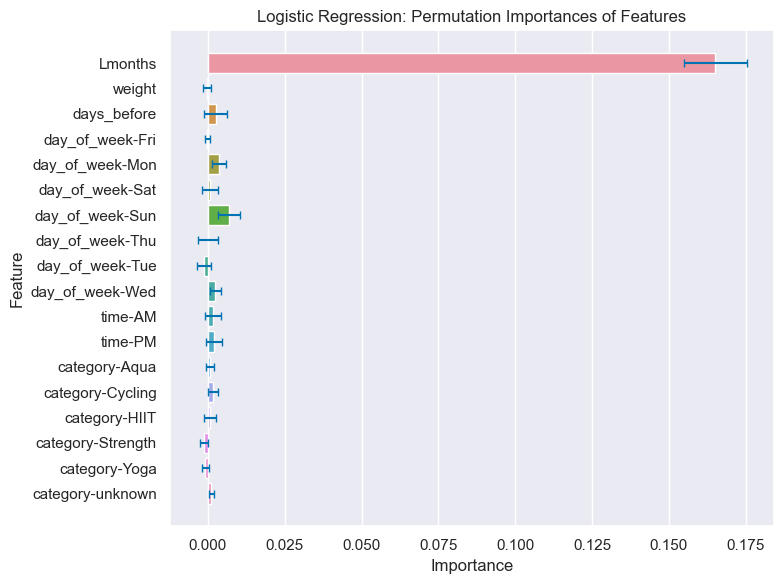

Significant Importances
 -- Lmonths


In [30]:
# Try a logistic regression classifier
logreg = LogisticRegression(random_state=2023)

logreg.fit(X_train,y_train)

# Interpret the model's fit
result = permutation_importance(logreg, X_train, y_train, n_repeats=10, random_state=0)
fig, ax = plt.subplots(figsize=(8,6))
styled_columns = [x.replace('category_','') for x in X_train.columns]
sns.barplot(x=[imp for imp in result.importances_mean], y=styled_columns, ax=ax)
ax.errorbar(x=result.importances_mean, y=styled_columns, xerr=result.importances_std,linestyle='',capsize=3)
ax.set_title('Logistic Regression: Permutation Importances of Features')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.tight_layout()

plt.show()

print("Significant Importances")
for idx, (imp, std) in enumerate( zip(result.importances_mean,result.importances_std) ) :
    if np.abs(imp) > 2*std :
        print(f" -- {styled_columns[idx]}")

Continuing on, let's look at how this model performs on the training set:

In [31]:
y_train_prob_logreg = logreg.predict_proba(X_train)[:,1]
y_test_prob_logreg = logreg.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       837
           1       0.70      0.51      0.59       363

    accuracy                           0.79      1200
   macro avg       0.76      0.71      0.72      1200
weighted avg       0.78      0.79      0.78      1200



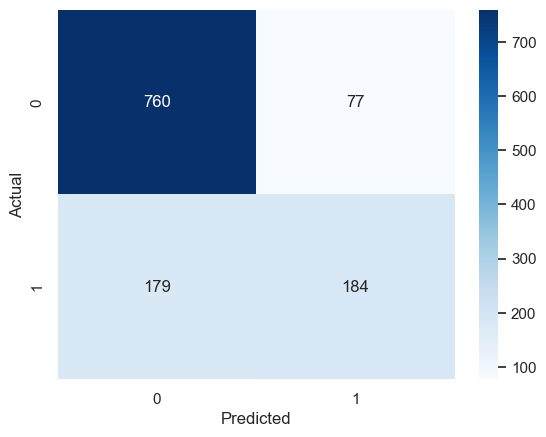

Accuracy: 0.7867
Balanced Accuracy 0.7074


In [32]:
# choose an arbitrary probability threshold of 0.5 for a first look
print(classification_report(y_train, y_train_prob_logreg>0.5))

cm = confusion_matrix(y_train, y_train_prob_logreg>0.5)

fig, ax = plt.subplots()
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=['0','1'], yticklabels=['0','1'], ax=ax)

ax.set_title('')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

print(f"Accuracy: {accuracy_score(y_train,y_train_prob_logreg>0.5):.4f}")
print(f"Balanced Accuracy {balanced_accuracy_score(y_train,y_train_prob_logreg>0.5):.4f}")

We have a decent overall accuracy of 79% on the test set, but a worse balanced accuracy of 71%. This is because the model is more accurate in correctly identifying the class that has more occurrences in the dataset (the `not-attended` label). Since the data is not balanced across the target variable `attended`, it is important correct for this by choosing a statistic that takes into account the relative proportion of each target class.
For this reason, the statistic that I'll use to capture the performance of the model is the `balanced accuracy score`.

However, I still haven't tuned the final hyperparameter: the probability threshold for choosing whether the model has classified a booking as attended or not. Below we see that a threshold of ~0.3 is optimal for balanced accuracy, pushing the score up to ~75%. 

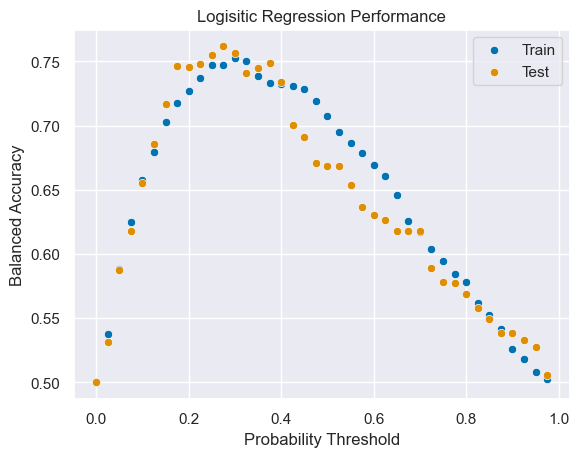

Training Balanced Accuracy at 0.3: 0.7529


In [33]:
n_thresh = 40
thresholds = [x/n_thresh for x in range(n_thresh)]

bal_accuracies = [ balanced_accuracy_score(y_train,y_train_prob_logreg>thresh) for thresh in thresholds ]
bal_accuracies_test = [ balanced_accuracy_score(y_test,y_test_prob_logreg>thresh) for thresh in thresholds ]

fig, ax = plt.subplots()
g=sns.scatterplot(x=thresholds, y=bal_accuracies, ax=ax)
g=sns.scatterplot(x=thresholds, y=bal_accuracies_test, ax=ax)

g.set(title="Logisitic Regression Performance")
g.set(xlabel='Probability Threshold')
g.set(ylabel='Balanced Accuracy')
plt.legend(labels=['Train','Test'])
plt.show()

logreg_threshold=0.3
print(f"Training Balanced Accuracy at {logreg_threshold}: {balanced_accuracy_score(y_train,y_train_prob_logreg>logreg_threshold):.4f}")

In [34]:
all_train['prob_logreg'] = y_train_prob_logreg
all_train['pred_logreg'] = y_train_prob_logreg>logreg_threshold

## Comparison Model -- Support Vector Machine

Since I have observed some degree of clustering during the exploratory analysis, I will try an SVM Classifier as an alternative model. 

In [35]:
svm = SVC(random_state=2023, probability=True)

svm_grid = {
    'C' : [0.001,0.01,0.1,0.5], # extending C to 1 and above results in overfitting, judging by previously-run threshold vs accuracy figure just below
    'degree' : [1,2]
}

In [36]:
t0 = perf_counter()

search_cv = GridSearchCV(estimator=svm, 
                         param_grid=svm_grid,
                         scoring="balanced_accuracy",
                         cv=5)
search_cv.fit(X_train,y_train)

best_svm = search_cv.best_estimator_
best_svm_hypers = search_cv.best_params_
avg_svm_score = search_cv.best_score_

print(f"For {best_svm=} the best balanced accuracy is {avg_svm_score:.3F} with args {best_svm_hypers}")
t1 = perf_counter()
print(f"Ran in {t1-t0:.1f} seconds")

For best_svm=SVC(C=0.5, degree=1, probability=True, random_state=2023) the best balanced accuracy is 0.670 with args {'C': 0.5, 'degree': 1}
Ran in 4.2 seconds


After fitting the SVM, it's clear that again the membership duration `Lmonths` is still the most important feature for predicting attendance. However in this model, there are many more features with importances that are statistically significant.

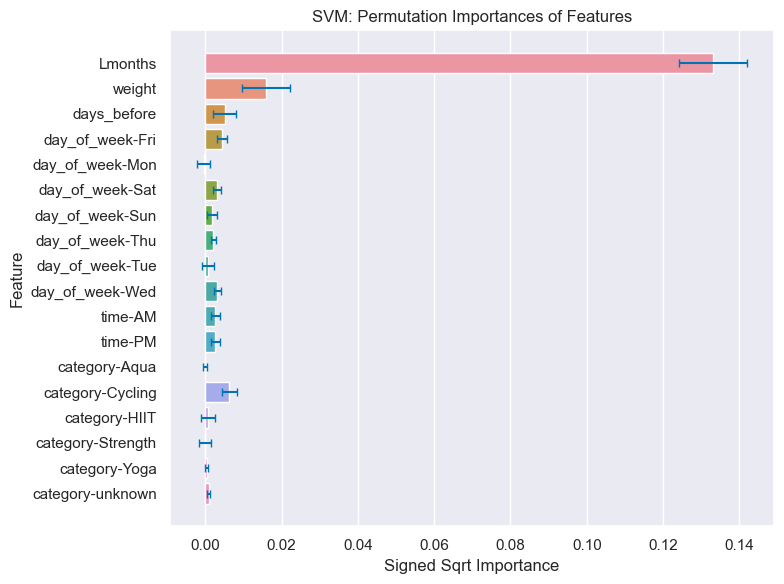

Significant Importances
 -- Lmonths
 -- weight
 -- day_of_week-Fri
 -- day_of_week-Sat
 -- day_of_week-Thu
 -- day_of_week-Wed
 -- time-AM
 -- time-PM
 -- category-Cycling
 -- category-unknown


In [37]:
# Interpret the model's fit
result = permutation_importance(best_svm, X_train, y_train, n_repeats=10, random_state=0)
fig, ax = plt.subplots(figsize=(8,6))
styled_columns = [x.replace('category_','') for x in X_train.columns]
sns.barplot(x=[imp for imp in result.importances_mean], y=styled_columns, ax=ax)
ax.errorbar(x=result.importances_mean, y=styled_columns, xerr=result.importances_std,linestyle='',capsize=3)
ax.set_title('SVM: Permutation Importances of Features')
ax.set_xlabel('Signed Sqrt Importance')
ax.set_ylabel('Feature')
plt.tight_layout()

plt.show()

print("Significant Importances")
for idx, (imp, std) in enumerate( zip(result.importances_mean,result.importances_std) ) :
    if np.abs(imp) > 2*std :
        print(f" -- {styled_columns[idx]}")

In [38]:
y_train_prob_svm = best_svm.predict_proba(X_train)[:,1]
y_test_prob_svm = best_svm.predict_proba(X_test)[:,1]

For the SVM it looks like the optimal threshold actually occurs at a probability threshod of 0.2, achieving a balanced accuracy of 76.7%.

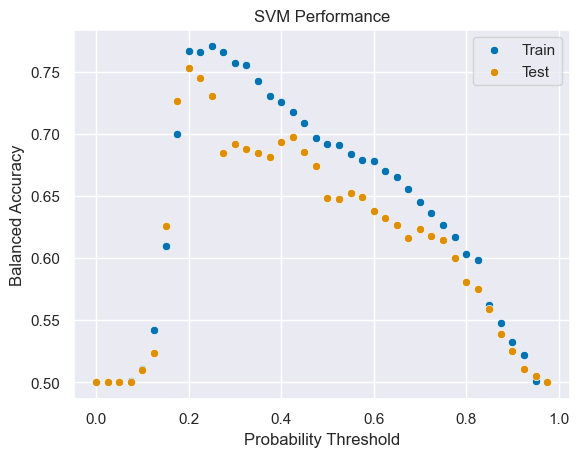

Training Balanced Accuracy at 0.2: 0.7668


In [39]:
n_thresh = 40
thresholds = [x/n_thresh for x in range(n_thresh)]

bal_accuracies = [ balanced_accuracy_score(y_train,y_train_prob_svm>thresh) for thresh in thresholds ]
bal_accuracies_test = [ balanced_accuracy_score(y_test,y_test_prob_svm>thresh) for thresh in thresholds ]

fig, ax = plt.subplots()
g=sns.scatterplot(x=thresholds, y=bal_accuracies, ax=ax)
g=sns.scatterplot(x=thresholds, y=bal_accuracies_test, ax=ax)
g.set(title="SVM Performance")
g.set(xlabel='Probability Threshold')
g.set(ylabel='Balanced Accuracy')
plt.legend(labels=['Train','Test'])
plt.show()

svm_threshold = 0.2
print(f"Training Balanced Accuracy at {svm_threshold}: {balanced_accuracy_score(y_train,y_train_prob_svm>svm_threshold):.4f}")

In [40]:
all_train['prob_svm'] = y_train_prob_svm
all_train['pred_svm'] = y_train_prob_svm>svm_threshold

all_train_undummy = unget_dummies(all_train)

## Model Choices

The above two models, the Logistic Regression Classifier and the Support Vector Machine Classifier, were chosen for similar and also separate reasons. The business goal -- of being able to predict whether a member will attend their booked class -- is a binary classification problem, so classifier models were chosen rather than e.g. regression models or unsupervised clustering models. 

The Logistic Regression Classifier was chosen as a baseline model because it is easily interpretable while giving relatively good performance despite its simplicity. The Support Vector Machine Classifier was chosen because clustering was noted in the exploratory analysis, and as a clustering model similar to KNN the SVM might excel at the given task.

## Model Comparison

One good way of showing off the efficacy of a model is to see how well the distribution of predictions follows the distributions of observations on the same dataset. For example, below are the distributions of attendance rates in the training data itself, from logistic regression predictions on the training set, and from the SVM predictions on the training set. The Logistic Regression predictions, while not as spread out as the raw data, still look very similar to the raw data, especially when the fit lines are compared. In contrast the SVM predictions are markedly different from the actual data, with noticeably different lower and upper bounds for the attendance probability.

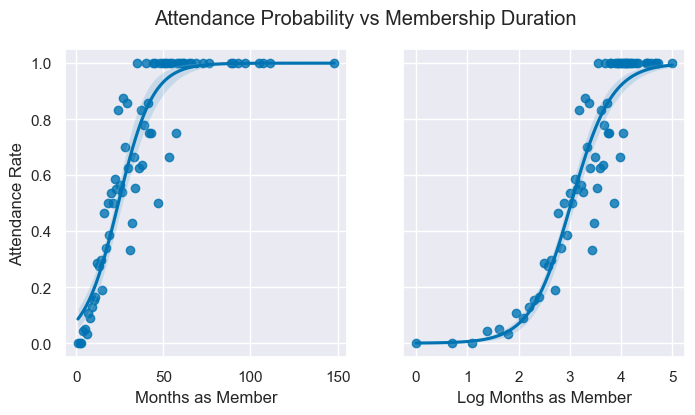

In [41]:
fig_month_data

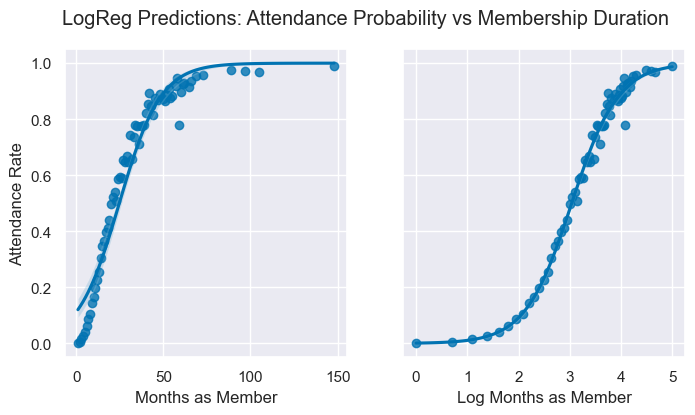

In [42]:
# comparing logistic regression to the training data's attendance vs membership duration
fig_month_logreg, axs = plt.subplots(1,2,figsize=(8,4), sharey=True)

attendance_proportion_months = all_train.groupby('months_as_member',as_index=False)['prob_logreg'].mean()
g1 = sns.regplot(data=attendance_proportion_months,x='months_as_member',y='prob_logreg', logistic=True, ax=axs[0])
g1.set(xlabel='Months as Member')
g1.set(ylabel='Attendance Rate')

attendance_proportion_Lmonths = all_train.groupby('Lmonths',as_index=False)['prob_logreg'].mean()
g2 = sns.regplot(data=attendance_proportion_Lmonths,x='Lmonths',y='prob_logreg', logistic=True, ax=axs[1])
g2.set(xlabel='Log Months as Member')
g2.set(ylabel='')

plt.suptitle('LogReg Predictions: Attendance Probability vs Membership Duration')
plt.show()

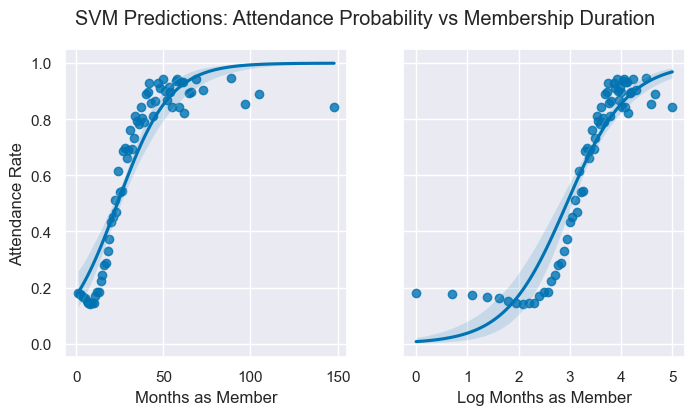

In [43]:
# comparing SVM to the training data's attendance vs membership duration
fig_month_svm, axs = plt.subplots(1,2,figsize=(8,4), sharey=True)

attendance_proportion_months = all_train.groupby('months_as_member',as_index=False)['prob_svm'].mean()
g1 = sns.regplot(data=attendance_proportion_months,x='months_as_member',y='prob_svm', logistic=True, ax=axs[0])
g1.set(xlabel='Months as Member')
g1.set(ylabel='Attendance Rate')

attendance_proportion_Lmonths = all_train.groupby('Lmonths',as_index=False)['prob_svm'].mean()
g2 = sns.regplot(data=attendance_proportion_Lmonths,x='Lmonths',y='prob_svm', logistic=True, ax=axs[1])
g2.set(xlabel='Log Months as Member')
g2.set(ylabel='')

plt.suptitle('SVM Predictions: Attendance Probability vs Membership Duration')
plt.show()

Examining also the attendance rates by day/time -- across the training data itself, the Logistic Regression predictions, and the SVM predictions -- we see that both models adequately capture the patterns seen in the data. Interestingly, both models capture the observed AM/PM attendance rate reversal on Saturday classes. However, while the maximum attendance rate in the dataset at a particular day/time slot is 0.35, the models both overshoot to an attendance probability of 0.5 or more in some time slots. The SVM has no time slots with less than a 0.2 attendance rate, in contrast to the data (and Logistic Regression model) which have Wednesday PM drop to an attendance rate of ~0.16.

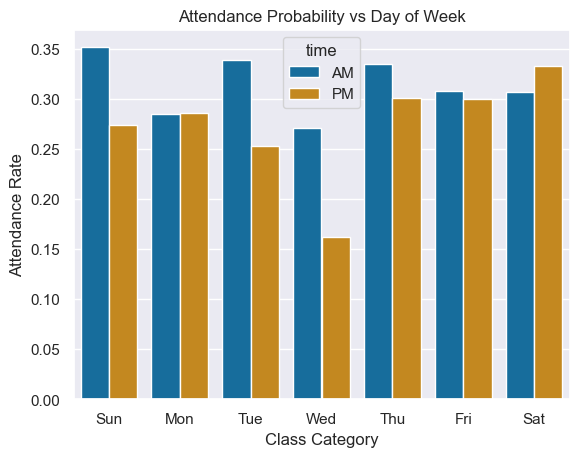

In [44]:
fig_daytime_data

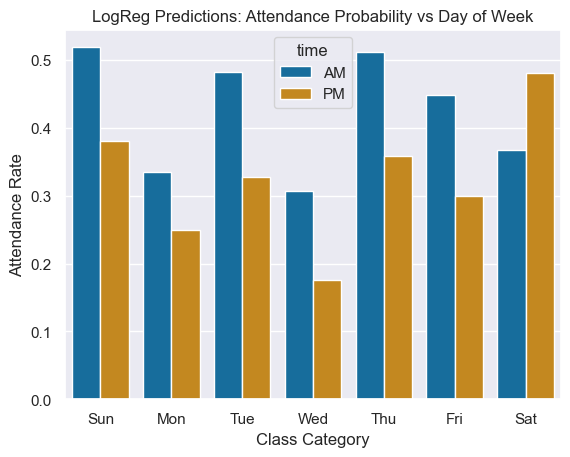

In [45]:
# comparing logistic regression to the training data's attendance rate vs day/time
attendance_proportion_category = all_train_undummy.groupby(['day_of_week','time'],as_index=False)['pred_logreg'].mean()
fig_daytime_logreg, ax = plt.subplots()
sns.barplot(data=attendance_proportion_category,x='day_of_week',y='pred_logreg', hue='time',ax=ax, order=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
ax.set_xlabel('Class Category')
ax.set_ylabel('Attendance Rate')
ax.set_title('LogReg Predictions: Attendance Probability vs Day of Week')
plt.show()

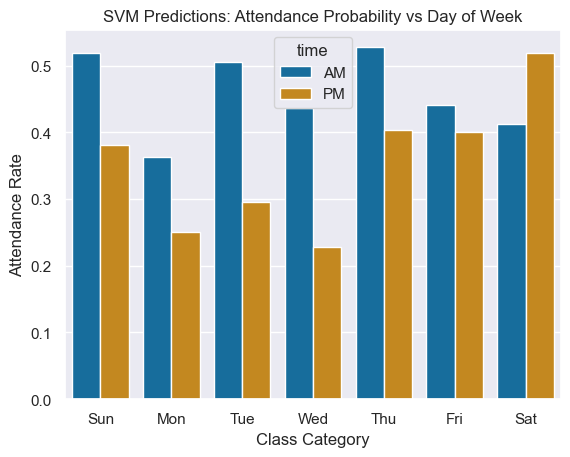

In [46]:
# comparing SVM to the training data's attendance rate vs day/time
attendance_proportion_category = all_train_undummy.groupby(['day_of_week','time'],as_index=False)['pred_svm'].mean()
fig_daytime_svm, ax = plt.subplots()
sns.barplot(data=attendance_proportion_category,x='day_of_week',y='pred_svm', hue='time',ax=ax, order=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
ax.set_xlabel('Class Category')
ax.set_ylabel('Attendance Rate')
ax.set_title('SVM Predictions: Attendance Probability vs Day of Week')
plt.show()

With the weight plots, it appears that both models approximate the general shape of the distribution fairly well. However, both models overestimate the attendance probability among the lighter members.

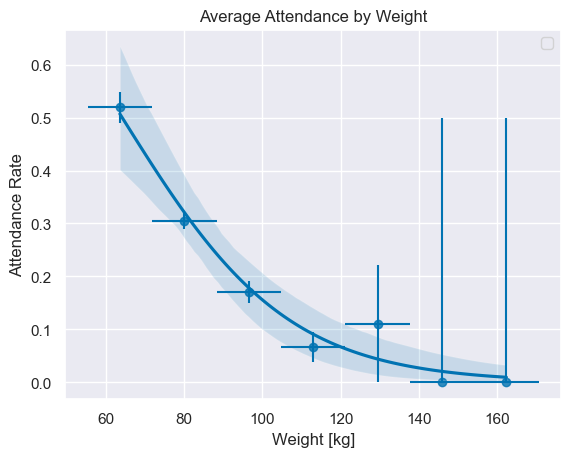

In [47]:
fig_weight_data

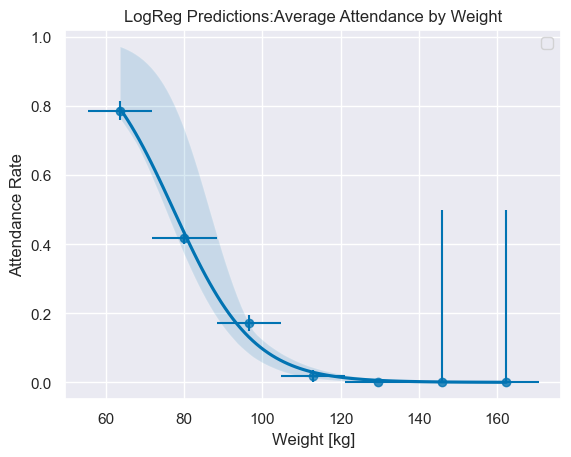

In [48]:
# comparing logistic regression to the training data's attendance vs weight

bins_weight, props_weight, errs_weight  = get_binxs_props_sigmas(all_train,'weight',label_col='pred_logreg')
corr_coef_weight = np.corrcoef(bins_weight, props_weight)[0,1]
fig_weight_logreg, ax = plt.subplots()
g = sns.regplot(x=bins_weight,y=props_weight, ax=ax, logistic=True)
ax.errorbar(x=bins_weight, y=props_weight, yerr=errs_weight, xerr=(bins_weight[1]-bins_weight[0])/2, ecolor=sns.color_palette()[0],ls='None' )
g.set(xlabel="Weight [kg]")
g.set(ylabel="Attendance Rate")
g.set(title="LogReg Predictions:Average Attendance by Weight")
ax.legend()
plt.show()

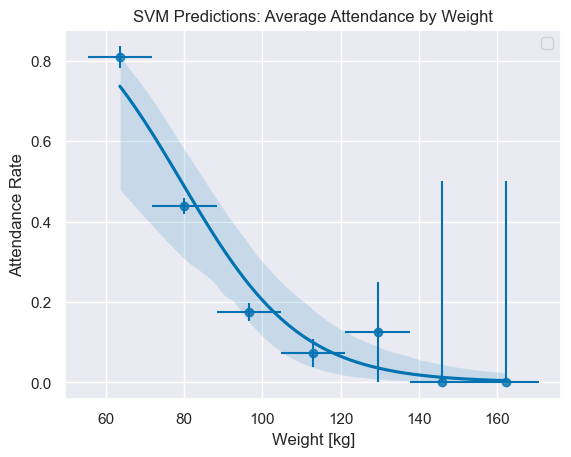

In [49]:
# comparing SVM to the training data's attendance vs weight

bins_weight, props_weight, errs_weight  = get_binxs_props_sigmas(all_train,'weight',label_col='pred_svm')
corr_coef_weight = np.corrcoef(bins_weight, props_weight)[0,1]
fig_weight_svm, ax = plt.subplots()
g = sns.regplot(x=bins_weight,y=props_weight, ax=ax, logistic=True)
ax.errorbar(x=bins_weight, y=props_weight, yerr=errs_weight, xerr=(bins_weight[1]-bins_weight[0])/2, ecolor=sns.color_palette()[0],ls='None' )
g.set(xlabel="Weight [kg]")
g.set(ylabel="Attendance Rate")
g.set(title="SVM Predictions: Average Attendance by Weight")
ax.legend()

Among the membership duration vs member weight plots, I'm particularly impressed by the SVM. While the Logistic Regression model appears to have a soft cutoff for attendance around `Lmonth`~2.7, the SVM more organically emulates the training data.

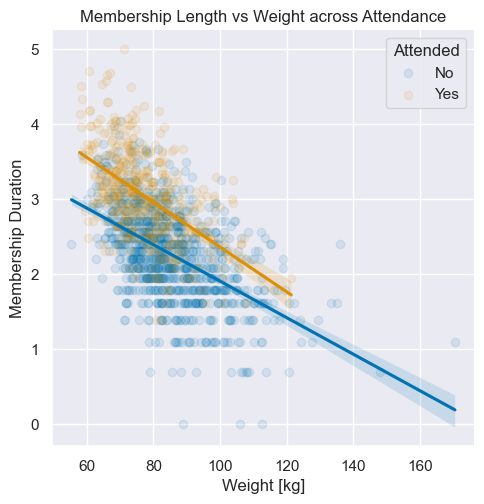

In [50]:
fig_lengthweight_data

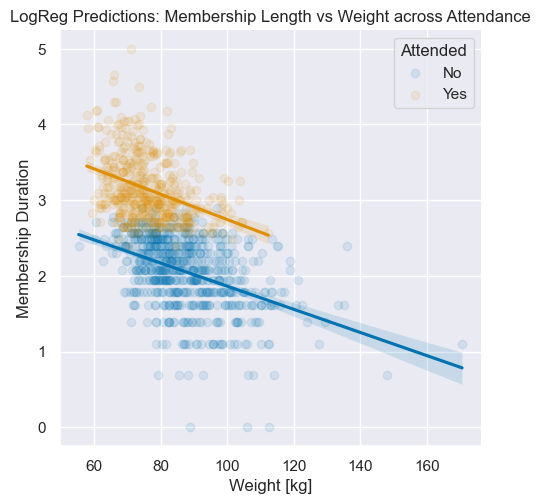

In [51]:
g = sns.lmplot(data=all_train, x='weight',y='Lmonths', hue='pred_logreg', legend_out=False, scatter_kws={'alpha':0.1})
g.set(xlabel='Weight [kg]')
g.set(ylabel='Membership Duration')
g.set(title='LogReg Predictions: Membership Length vs Weight across Attendance')
g._legend.set_title('Attended')
for t, l in zip(g._legend.texts, ['No','Yes']):
    t.set_text(l)
    
fig_lengthweight_logreg = g.figure
plt.show()

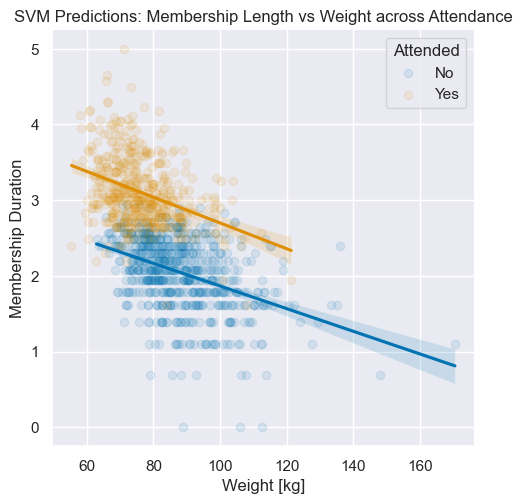

In [52]:
g = sns.lmplot(data=all_train, x='weight',y='Lmonths', hue='pred_svm', legend_out=False, scatter_kws={'alpha':0.1})
g.set(xlabel='Weight [kg]')
g.set(ylabel='Membership Duration')
g.set(title='SVM Predictions: Membership Length vs Weight across Attendance')
g._legend.set_title('Attended')
for t, l in zip(g._legend.texts, ['No','Yes']):
    t.set_text(l)
    
fig_lengthweight_svm = g.figure
plt.show()

Finally, we can compare each model's overall attendance predictions to the dataset. Both the Logistic Regression model and the Support Vector Machine underestimate the number of `no-show` bookings.

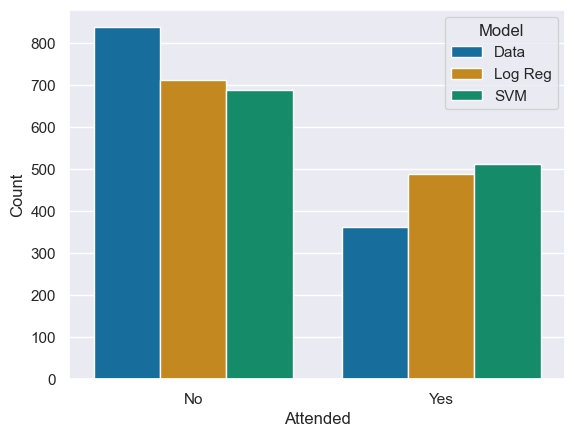

In [53]:
counts = np.concatenate( (all_train['attended'].value_counts().values,
                          all_train['pred_logreg'].value_counts().values,
                          all_train['pred_svm'].value_counts().values) ) 
model_summary_df = pd.DataFrame({'Attended' : ['No','No','No','Yes','Yes','Yes'],
                                 'Model' : ['Data','Log Reg','SVM','Data','Log Reg','SVM'],
                                'Count' : [counts[0], counts[2], counts[4], counts[1], counts[3], counts[5]]})

sns.barplot(data=model_summary_df,x='Attended',y='Count',hue='Model')
plt.show()

## Model Ranking

Across the training set, the Logistic Regression Classifier achieved a balanced accuracy of 75.3% while the SVM achieved a balanced accuracy of 76.7%. However, the SVM fails to maintain this accuracy in withheld test data, achieving a balanced accuracy of only 75.3%, while the Logistic Regression model holds a steady 75.6% still in the test data. This means that the Logistic Regression model has more external validity (generalizes better to new data), and should therefore better achieve the business goal of being able to predict whether or not a member will attend their booked class.

In [54]:

print(f"Training Set")
print(f"Balanced Accuracy Logistic {balanced_accuracy_score(y_train,y_train_prob_logreg>logreg_threshold):.4f}")
print(f"Balanced Accuracy SVM {balanced_accuracy_score(y_train,y_train_prob_svm>svm_threshold):.4f}")

print(f"\nTest Set")
print(f"Balanced Accuracy Logistic {balanced_accuracy_score(y_test,y_test_prob_logreg>logreg_threshold):.4f}")
print(f"Balanced Accuracy SVM {balanced_accuracy_score(y_test,y_test_prob_svm>svm_threshold):.4f}")

Training Set
Balanced Accuracy Logistic 0.7529
Balanced Accuracy SVM 0.7668

Test Set
Balanced Accuracy Logistic 0.7564
Balanced Accuracy SVM 0.7530


### Summary and Recommendations

We have been provided a dataset with the goal of predicting whether or not a member will actually attend a booked class. Two models have been fit to the cleaned and imputed data, with the **Logistic Regression Classifier** having been chosen as the best model after achieving a balanced accuracy of 75%. 

The model can now be sent off to the backend team to be merged with the booking system. When a booking is predicted by the model to be a `no-show`, the backend scheduling system can then add a new slot to the class.

This model should be re-evaluated at least quarterly to ensure that it is performing well. The model could be improved by performing a cost estimation for overbooked and underbooked classes, which would allow for a better statistic to be chosen over the simple balanced accuracy metric used here.